# Exploratory data analysis 



## 1. Importing modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import ipywidgets as widgets

# for modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances, davies_bouldin_score, calinski_harabasz_score
from sklearn.pipeline import Pipeline
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
import utils

## 2. Loading data

1. Socio economic: Keep the following variables:
    * HDI
    * life expectancy
    * mortality rate
    * population growth
    * GDP per capita PPP
    * for rural & urban we make new variables rural/urban (so the ratio of the population living in rural areas over urban areas)
        * r_u : a variable that indicates the proportion of rural over urban population
        * r_u_access : a variable that indicates the proportion of the rural population with access to safe drinking water    
2. Water stress: we use the water stress (MDG) and water efficiency as separate targets and therefore drop the water stress (SDG)
    

#### Socio econonomic 

In [2]:
df = pd.read_csv('clean data/socioec_factors.csv', index_col=0)
df.sample(5)

,Country,rural_pop,urban_pop,HDI,r_u,r_u_access,pop_growth,mort_rate,GDP_pcp,life_ex
89,MOZ,19149.788,10519.046,0.442,1.820487,0.459057,2.84,61.6,1240.6,57.0
65,ISR,637.763,7683.807,0.904,0.083001,1.000000,1.94,3.0,37873.6,82.2
137,WSM,160.194,36.246,0.706,4.419633,1.018462,0.66,14.6,6120.0,72.8
92,MYS,7764.814,23859.450,0.802,0.325440,0.930000,1.36,7.0,24751.4,75.4
97,NOR,961.814,4343.569,0.953,0.221434,1.000000,1.00,2.0,61792.4,82.2


#### Water stress data

In [3]:
df_ws = pd.read_csv('clean data/water_stress.csv')
df_ws.sample(5)

,Country,WS_MDG,WUE_SDG,WS_SDG
42,DEU,15.872078,128.567339,33.501919
126,PAK,81.037277,1.435568,122.691859
159,TGO,1.517007,13.405166,3.391635
81,JAM,12.473436,8.647571,12.473436
149,SSD,1.329293,19.179805,4.226076


#### Climate factors

In [4]:
df_climate = pd.read_csv('clean data/climate_factors.csv', index_col=0)
df_climate = df_climate.set_axis(
    ["Country", "Temp", "Rainfall", "IRWR", "ERWR", "TRWR", "Dep_r"], axis=1)
df_climate.head()

,Country,Temp,Rainfall,IRWR,ERWR,TRWR,Dep_r
0,AFG,14.074742,349.736945,47.1500,18.18,65.3300,0.278280
1,AGO,22.182196,960.024065,148.0000,0.40,148.4000,0.002695
2,ALB,12.754647,1079.459167,26.9000,3.30,30.2000,0.109272
3,AND,12.402212,760.241065,0.3156,0.00,0.3156,0.000000
4,ARE,28.010773,64.449765,0.1500,0.00,0.1500,0.000000


In [5]:
# merge aquastat with water stress.
# left merge to only keep aquastat countries
df_piv_ws = pd.merge(df, df_ws, on=["Country"], how='left')
df_piv_ws.sample(5)

,Country,rural_pop,urban_pop,HDI,r_u,r_u_access,pop_growth,mort_rate,GDP_pcp,life_ex,WS_MDG,WUE_SDG,WS_SDG
6,AUS,3446.638,21003.923,0.937,0.164095,1.000000,1.58,3.2,48074.8,82.2,3.240854,72.279751,6.411339
70,KHM,12327.338,3678.035,0.578,3.351610,0.691000,1.58,27.4,3552.4,68.6,0.458727,6.999747,1.036545
68,KEN,36498.515,13201.347,0.574,2.764757,0.696078,2.50,35.8,3829.0,64.6,13.133550,10.551287,33.239901
13,BGR,1794.614,5289.957,0.813,0.339249,0.993976,-0.64,7.0,19690.6,74.8,26.563380,7.930079,41.821273
118,SWE,1273.943,8636.758,0.935,0.147502,1.000000,1.10,2.0,51153.8,82.0,1.364943,194.076472,3.427128


In [6]:
# final dataset
df1 = df_piv_ws[['Country', 'HDI', 'r_u', 'r_u_access',
                 'pop_growth', 'mort_rate', 'life_ex', 'GDP_pcp']]
df1.head()

,Country,HDI,r_u,r_u_access,pop_growth,mort_rate,life_ex,GDP_pcp
0,AFG,0.493,2.960340,0.601023,3.06,53.2,63.4,2226.0
1,AGO,0.576,0.542292,0.374005,3.44,58.6,59.2,7859.4
2,ALB,0.789,0.683985,1.003161,-0.20,8.6,78.0,12227.4
3,ARE,0.864,0.159447,1.004016,0.74,7.0,77.2,64243.0
4,ARG,0.832,0.089930,1.010101,1.08,10.2,76.0,23732.2


In [7]:
df_tmp = df1.copy()

## 3. Exploratory analysis

In this section we are going to inspect the behaviour of each variable and the relationship between them

### This includes:
* Univariate analysis
* Checking the correlations between predictors and target variables
* PCA analysis
* Clustering: k-means and spectral

### 3.1 Univariate exploratory analysis

#### 3.1.1  Checking the distribution per indicator

First, we standardize the variables:

In [8]:
# transform variables (std)
scaler = StandardScaler()
# get numeric data
num_d = df_tmp.drop(["Country"], axis=1)

In [9]:
# update the cols with their normalized values
df_tmp[num_d.columns] = scaler.fit_transform(num_d)

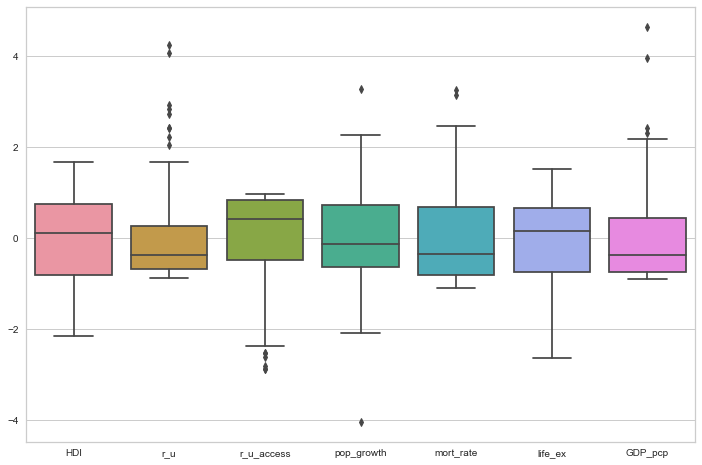

In [10]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(data=df_tmp)
plt.show()

- From the previous boxplots, we can see there are some outliers in the proportion of rural over urban population ( _r-u_ ), the proportion of the rural population with access to safe drinking water(_ru-access_) and _GDP_ . Also, few cases on pop_growth and mort_rate. We will explore this in more depth afterwards.

In [11]:
df_tmp.describe()

,HDI,r_u,r_u_access,pop_growth,mort_rate,life_ex,GDP_pcp
count,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.410000e+02,1.400000e+02,1.380000e+02
mean,-9.763663e-17,7.558965e-17,-5.228284e-16,9.133750e-17,3.149569e-17,-1.002373e-15,-1.206764e-17
std,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003565e+00,1.003591e+00,1.003643e+00
min,-2.154931e+00,-8.773345e-01,-2.877951e+00,-4.039730e+00,-1.089972e+00,-2.636227e+00,-8.860912e-01
25%,-8.108036e-01,-6.835928e-01,-4.830675e-01,-6.405242e-01,-8.104029e-01,-7.419929e-01,-7.320935e-01
50%,1.116368e-01,-3.676905e-01,4.197383e-01,-1.235943e-01,-3.476671e-01,1.695667e-01,-3.679509e-01
75%,7.441673e-01,2.696560e-01,8.339668e-01,7.379555e-01,6.838479e-01,6.609038e-01,4.423168e-01
max,1.666608e+00,4.241766e+00,9.764837e-01,3.275611e+00,3.257815e+00,1.527209e+00,4.649457e+00


<AxesSubplot:xlabel='variable', ylabel='value'>

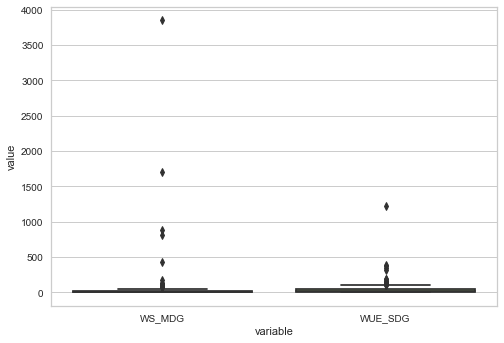

In [12]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_ws.iloc[:, 1:3]))
# clear outliers

<AxesSubplot:xlabel='variable', ylabel='value'>

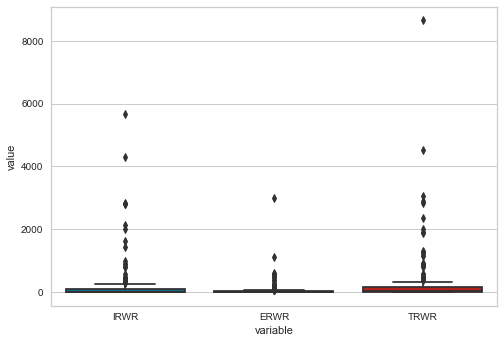

In [13]:
sns.boxplot(x="variable", y="value", data=pd.melt(
    df_climate[['IRWR', 'ERWR', 'TRWR']]))

<AxesSubplot:xlabel='variable', ylabel='value'>

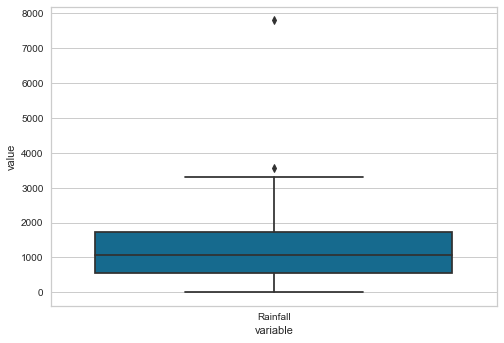

In [14]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_climate[['Rainfall']]))

<AxesSubplot:xlabel='variable', ylabel='value'>

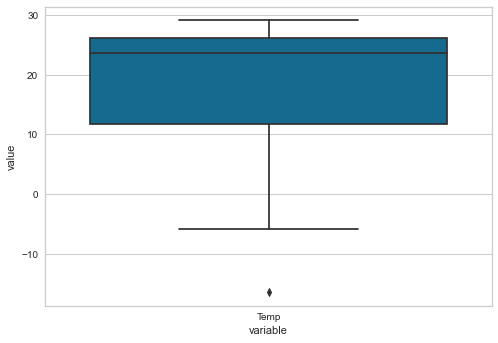

In [15]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_climate[['Temp']]))

<AxesSubplot:xlabel='variable', ylabel='value'>

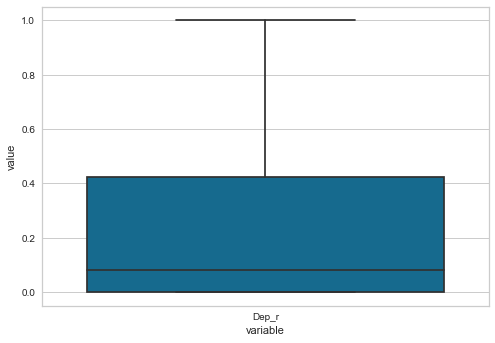

In [16]:
sns.boxplot(x="variable", y="value", data=pd.melt(df_climate[['Dep_r']]))

In [17]:
# df_climate.describe()

We can observe that the target variables have a distribution with many small values and a few very large values. If we take the *log()* of the target values the plots look a lot better and much more readable. This is something that we should keep in mind when creating model, especially regression models.

All the water resource explanatory variables suffer from a similar problem of having varied values with many small values and a few very large values.

#### 3.1.2 Distribution of each indicator per country

In [18]:
print(df_tmp.isna().sum(axis=0))
df_tmp = df_tmp.dropna(axis=0)

Country       0
HDI           0
r_u           0
r_u_access    0
pop_growth    0
mort_rate     0
life_ex       1
GDP_pcp       3
dtype: int64


<AxesSubplot:ylabel='Country'>

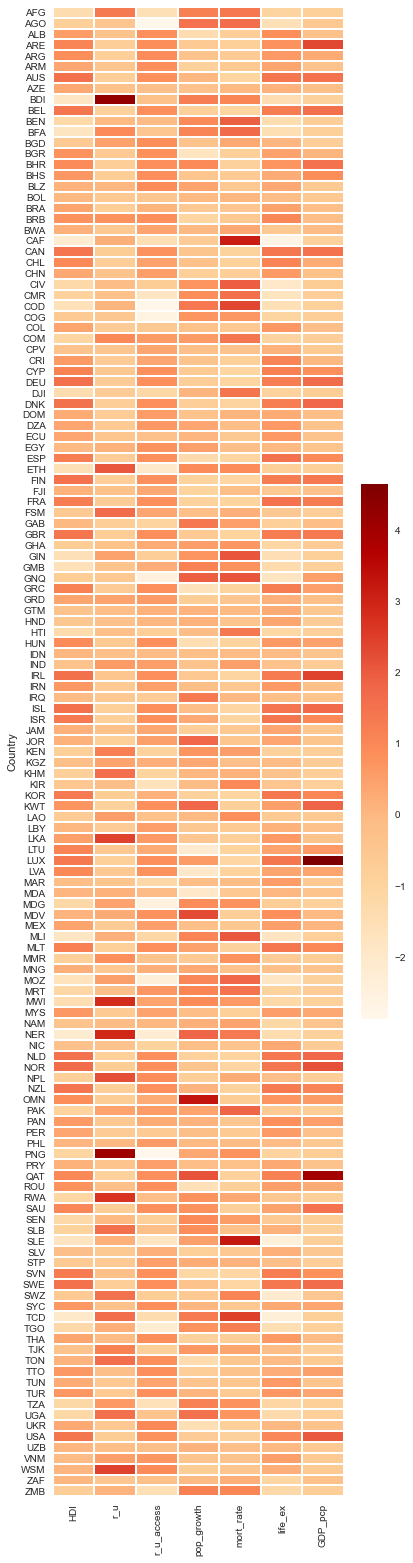

In [19]:
# setting index so heatmap can be plotted
df_tmp.set_index(['Country'], inplace=True)
plt.subplots(figsize=(6, .2*(len(df_tmp.index))))
sns.heatmap(df_tmp,
            cbar_kws={'fraction': 0.08},  # shrink colour bar
            cmap='OrRd',  # use orange/red colour map
            linewidth=1)

- From above we can see that the outliers from GDP are countries like QAT, LUX, ARE, IRL ...
- PNG & BDI have high ratio of rural pop (r_u)
- OMN QAT MDV have high pop growth 
- SLE, CAF, TCD have large mort_rate

### 3.2 Bivariate Analysis

#### 3.2.1 Checking the correlation between variables

<AxesSubplot:>

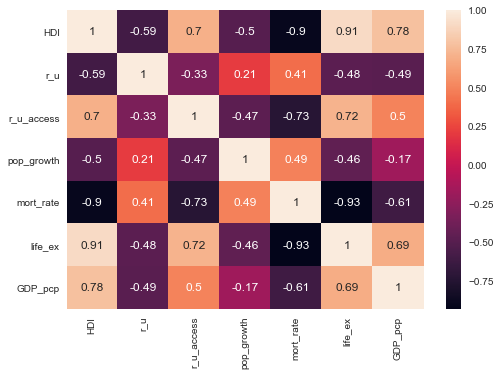

In [20]:
corr_data = df_tmp.corr()
sns.heatmap(corr_data, annot=True)

- The heatmap shows that the mortality rate is highly negatively correlated with HDI (-0.9) and life_ex (-0.93). HDI is highly correlated with the life expectancy.

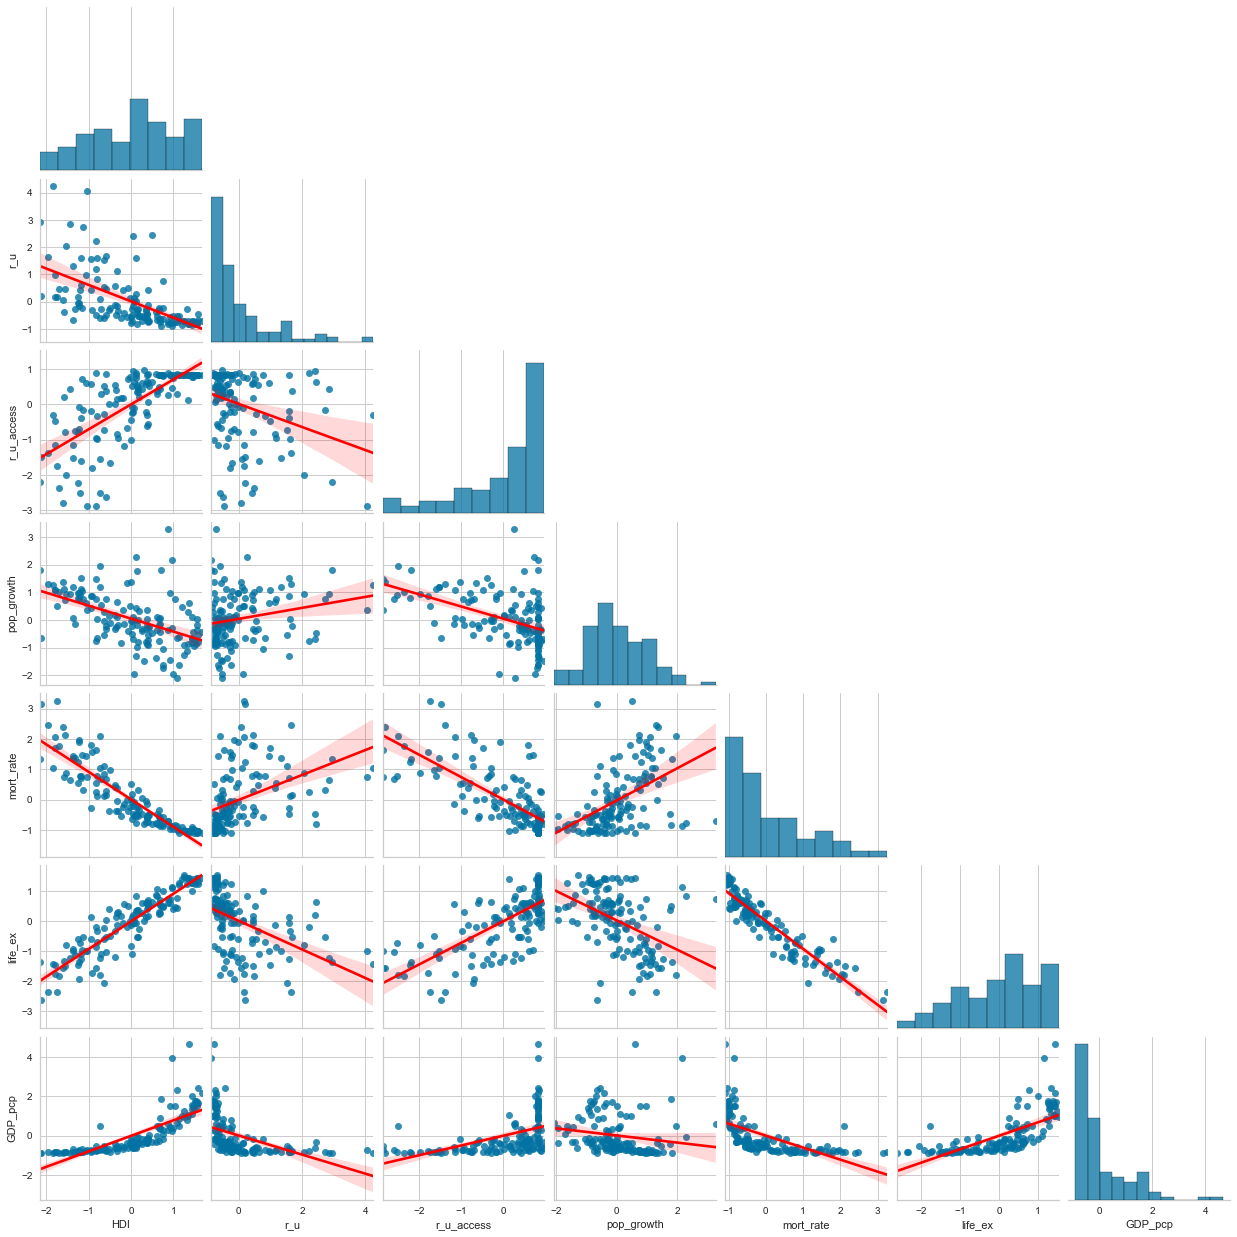

In [21]:
g = sns.pairplot(df_tmp, kind="reg", corner=True,
                 plot_kws={'line_kws': {'color': 'red'}})

#### 3.2.2 Hierarchical Clustered Heatmap

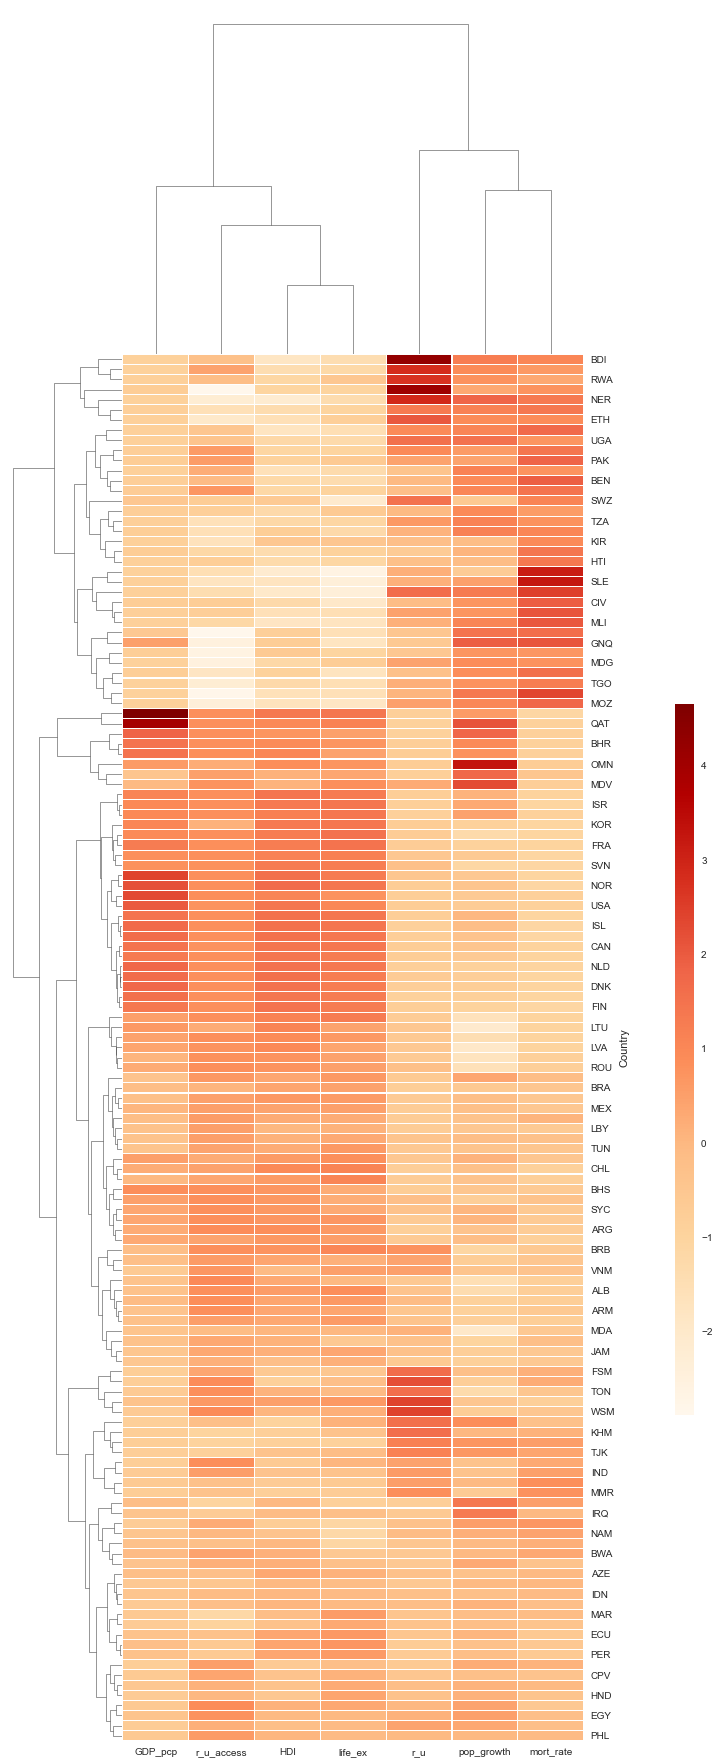

In [22]:
sns.clustermap(df_tmp,
               linewidth=0.05,
               cmap='OrRd',
               method='complete',
               figsize=(9, .18*(len(df_tmp.index))),
               cbar_pos=(1.05, .2, .03, .4))

- This clustered heatmap figure helps us identify countries with similar values across all indicators. Thus, countries are re ordered according to their similarity..

### 3.3 correlations

Conclusion: we expect water stress will be hard to predict with socio-economic factors given the overall low correlations. The water usage efficiency should be slightly easier to predict because some predictors have higher correlations 

In [23]:
# merge the two datasets into 1 for later use
df_total = pd.merge(df, df_ws, on=['Country'], how='left')
# drop rows with missing values
df_total = df_total.dropna()

In [24]:
corr_stress = df_total.corr()['WS_MDG'].sort_values(ascending=False)
corr_effiency = df_total.corr()['WUE_SDG'].sort_values(ascending=False)
print('correlations with stress : \n', corr_stress)
print('correlations with effiency : \n', corr_effiency)

correlations with stress : 
 WS_MDG        1.000000
WS_SDG        0.999498
GDP_pcp       0.273908
pop_growth    0.159887
r_u_access    0.141995
HDI           0.127326
life_ex       0.095724
WUE_SDG       0.040949
urban_pop    -0.033059
rural_pop    -0.033738
r_u          -0.135479
mort_rate    -0.136546
Name: WS_MDG, dtype: float64
correlations with effiency : 
 WUE_SDG       1.000000
GDP_pcp       0.659415
HDI           0.350520
life_ex       0.300403
r_u_access    0.184661
WS_MDG        0.040949
WS_SDG        0.037662
pop_growth   -0.006180
urban_pop    -0.056597
rural_pop    -0.076072
r_u          -0.221273
mort_rate    -0.251949
Name: WUE_SDG, dtype: float64


### 3.4 PCA analysis

#### 3.4.1 Create a copy of our data

In [25]:
data = df_total.copy()

#### 3.4.2 Scale the numeric data

In [26]:
# select numeric vars
num_d = data.select_dtypes(include=['float64'])

# Putting response variable to y
y = data['Country']

# scale the data
scaler = StandardScaler()
data[num_d.columns] = scaler.fit_transform(num_d)

#### 3.4.3 create a data set that only includes predictors to perform PCA

In [27]:
datX = data.drop(['Country', 'rural_pop', 'urban_pop',
                  'WS_SDG', 'WS_MDG', 'WUE_SDG'], axis=1)
datX.head()

,HDI,r_u,r_u_access,pop_growth,mort_rate,GDP_pcp,life_ex
0,-1.372006,1.505922,-1.617125,1.233024,1.364589,-0.818518,-1.003998
1,-0.837114,-0.439302,-3.010320,1.552530,1.619939,-0.543204,-1.530676
2,0.535563,-0.325316,0.850776,-1.508001,-0.744411,-0.329733,0.826834
3,1.018900,-0.747285,0.856022,-0.717644,-0.820070,2.212356,0.726514
4,0.812676,-0.803209,0.893365,-0.431770,-0.668752,0.232526,0.576035


#### 3.4.4 perform PCA

In [28]:
pca = PCA(n_components=5)
pca.fit(datX)  # obtain the principal components

# df_tmp2 will be used in clustering, don't pay attention to this
df_tmp2 = pca.transform(datX)
df_tmp2 = pd.DataFrame(df_tmp2)
df_tmp2.columns = ['P1', 'P2', 'P3', 'P4', 'P5']
df_tmp2 = df_tmp2[['P1', 'P2']]

# examine which variable leans on which component
colnames = list(datX.columns)
pcs_df = pd.DataFrame({'PC1': pca.components_[0],
                       'PC2': pca.components_[1],
                       'PC3': pca.components_[2],
                       'PC4': pca.components_[3],
                       'PC5': pca.components_[4],
                       'Feature': colnames})
pcs_df

,PC1,PC2,PC3,PC4,PC5,Feature
0,-0.448464,0.085892,-0.008392,-0.145509,-0.089067,HDI
1,0.300297,-0.381936,0.798764,-0.321830,-0.041152,r_u
2,-0.368693,-0.241819,0.334890,0.721349,0.416028,r_u_access
3,0.265624,0.759489,0.379068,0.363465,-0.258469,pop_growth
4,0.428991,0.072282,-0.161096,0.016437,0.517154,mort_rate
5,-0.357843,0.453890,0.238691,-0.467850,0.566751,GDP_pcp
6,-0.436035,0.014376,0.152108,-0.060389,-0.402284,life_ex


#### Conclusion: 
We notice that for PC1 all variables have a somewhat similar weight. PC2 is dominated by population growth and GDP per capita. PC3 is mainly the ratio of rural over urban population. PC4 is dominated by rural over urban population access to water. PC5 is a mix again.

#### 3.4.5 check how many components explain the variance

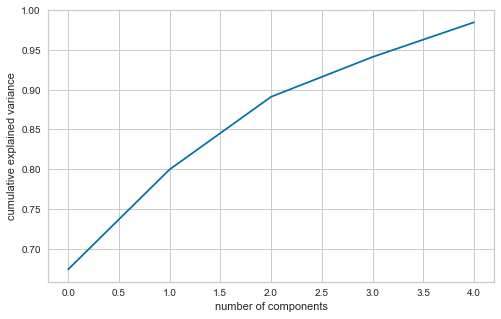

In [29]:
%matplotlib inline
fig = plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Conclusion:
We only need 2 components to explain ~90% of the variance.

#### 3.4.6 examine which variable weighs on PC1 and PC2

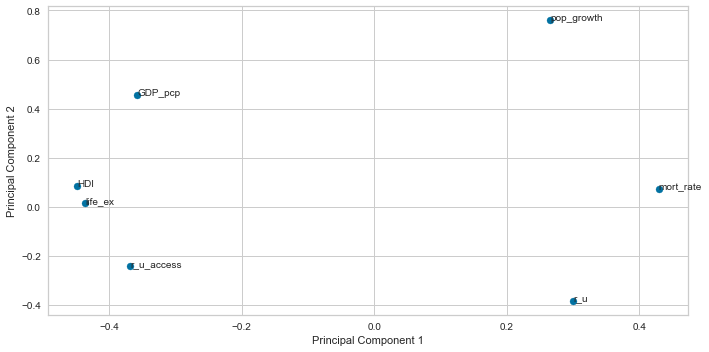

In [30]:
%matplotlib inline
fig = plt.figure(figsize=(10, 5))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i], pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### Conclusion:
PC1 is a balanced mix of everything. PC2 is dominated by population growth, GDP per capita and rural over urban population.

### 3.5 Clustering
3.5.1: we look at k-means.

3.5.2: we look at spectral clustering.

3.5.4: we evaluate the clustering algorithms based on the Silhouette score and David-Bouldin score.

3.5.5: we evaluate the clusters by looking how the variable values change for each cluster.

* Silhouette score for a set of sample data points is used to measure how dense and well-separated the clusters are. Silhouette score takes into consideration the intra-cluster distance between the sample and other data points within the same cluster (a) and inter-cluster distance between the sample and the next nearest cluster (b).
    * The silhouette plots can be used to select the most optimal value of the K (no. of cluster) in K-means clustering. The score ranges between [-1,1] with a score 1 meaning that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect.
* The Davies–Bouldin (DB) criterion is based on a ratio between “within-cluster” and “between-cluster” distances. The optimal clustering has the smallest Davies–Bouldin index value.
    * Eg. if two clusters are close together but have a large spread then this ratio will be large, indicating that these clusters are not very distinct.

### 3.5.1 K-means clustering

C:\Users\Andreas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


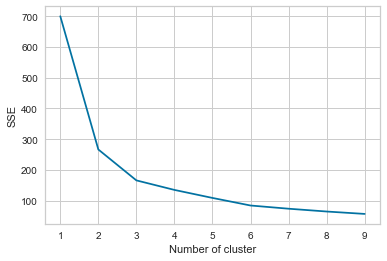

In [31]:
df_tmp_n = df_tmp2.copy()
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_tmp_n)
    df_tmp_n['clusters'] = kmeans.labels_
    # print(data["clusters"])
    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

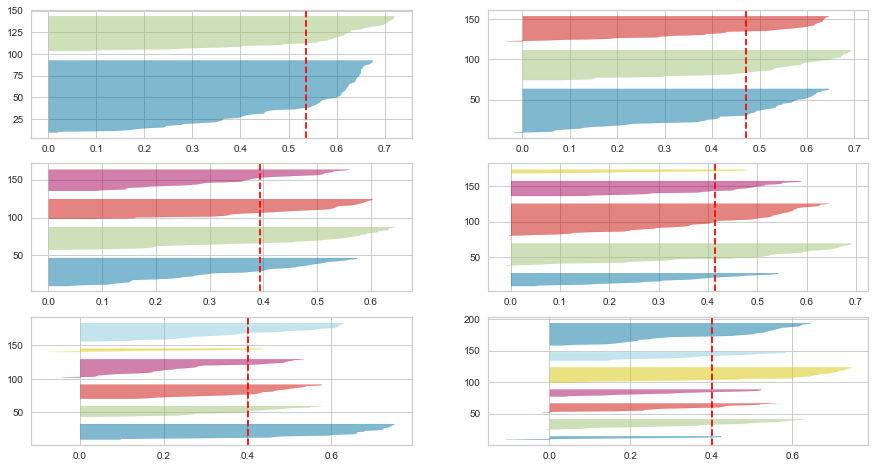

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(15, 8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++',
                n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(
        km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_tmp2)

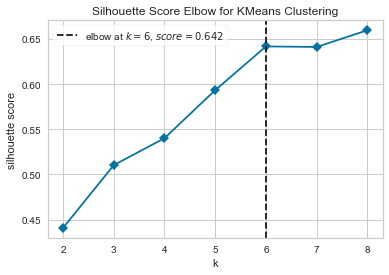

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [33]:
# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=42)

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(
    model, k=(2, 9), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(df_tmp_n)
visualizer.poof()

#### Conclusion:
K-means clustering with 5 clusters is optimal. A score of 0.556 indicates clustering works reasonably well.

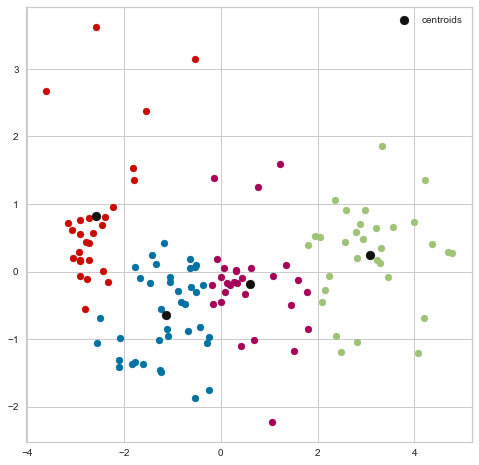

In [34]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_tmp2.values)
y_label = kmeans.predict(df_tmp2.values)

fix, ax = plt.subplots(1, 1, figsize=(8, 8))
for i in np.unique(y_label):
    idx = y_label == i
    ax.scatter(df_tmp2.values[idx, 0], df_tmp2.values[idx, 1])

# plotting the centroids
ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[
           :, 1], color='k', s=80.0, label='centroids')
ax.legend()

### 3.5.2 Spectral clustering

In [35]:
# 5 neighbours is standard practise
A = kneighbors_graph(df_tmp2.values, n_neighbors=5).toarray()

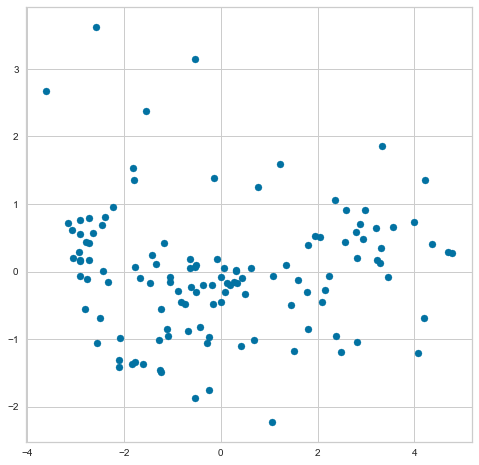

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(df_tmp2['P1'], df_tmp2['P2'])

In [37]:
D = np.diag(A.sum(axis=1))
L = D-A

In [38]:
vals, vecs = np.linalg.eig(L)
vals = np.real(vals)
vecs = np.real(vecs)

In [39]:
vecs_sorted = vecs[:, np.argsort((vals))]
vals_sorted = vals[np.argsort((vals))]

uncomment if you want to visualise eigenvalues


In [40]:
'''fig , ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(np.arange(0,len(vals_sorted)),abs(vals_sorted))
ax.set_title('Eigen values',fontsize=12);'''

"fig , ax = plt.subplots(1,1,figsize=(5,5))\nax.scatter(np.arange(0,len(vals_sorted)),abs(vals_sorted))\nax.set_title('Eigen values',fontsize=12);"

In [41]:
U = np.array((vecs_sorted[:, 1])).reshape(-1, 1)

In [42]:
km = KMeans(init='k-means++', n_clusters=5, random_state=42)
km.fit(U)

KMeans(n_clusters=5, random_state=42)

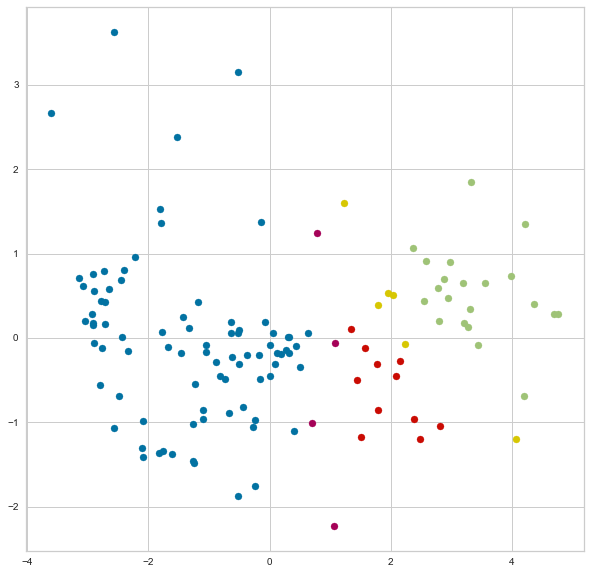

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.scatter(df_tmp2.values[km.labels_ == 0, 0],
            df_tmp2.values[km.labels_ == 0, 1])
plt.scatter(df_tmp2.values[km.labels_ == 1, 0],
            df_tmp2.values[km.labels_ == 1, 1])
plt.scatter(df_tmp2.values[km.labels_ == 2, 0],
            df_tmp2.values[km.labels_ == 2, 1])
plt.scatter(df_tmp2.values[km.labels_ == 3, 0],
            df_tmp2.values[km.labels_ == 3, 1])
plt.scatter(df_tmp2.values[km.labels_ == 4, 0],
            df_tmp2.values[km.labels_ == 4, 1])

5 clusters looks like overkill, we have 1 cluster containing only 4 datapoints

We now build a second spectral clustering model based on rbf affinity.

Uncomment the plotting part if you want to visualise.

In [44]:
# Building the clustering model
spectral_model_tmp = SpectralClustering(n_clusters=5,
                                        n_neighbors=5,
                                        random_state=42,
                                        affinity='rbf')

# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_tmp.fit_predict(df_tmp2)
df_tmp2['cluster_rbf'] = spectral_model_tmp.fit_predict(df_tmp2[['P1', 'P2']])
# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'g'
colours[2] = 'orange'
colours[3] = 'red'
colours[4] = 'gray'
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]

# Plotting the clustered scatter plot
'''
b = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='b');
y = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='g');
r = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='orange');
r1 = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='red');
gr = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='gray');
plt.figure(figsize =(9, 9))
plt.scatter(df_tmp2['P1'], df_tmp2['P2'], c = cvec)
plt.legend((b, y,r,r1,gr), ('C 1', 'C 2','C 3','C 4','C 5'))
plt.show()
'''

"\nb = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='b');\ny = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='g');\nr = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='orange');\nr1 = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='red');\ngr = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='gray');\nplt.figure(figsize =(9, 9))\nplt.scatter(df_tmp2['P1'], df_tmp2['P2'], c = cvec)\nplt.legend((b, y,r,r1,gr), ('C 1', 'C 2','C 3','C 4','C 5'))\nplt.show()\n"

We build a second spectral model based on nearest neighbours. Uncomment the plotting part if you want to visualize it.

In [45]:
spec_cl = SpectralClustering(
    n_clusters=4,
    n_neighbors=5,
    random_state=42,
    affinity='nearest_neighbors')

df_tmp2['cluster_cl'] = spec_cl.fit_predict(df_tmp2[['P1', 'P2']])

labels_nearest = spec_cl.fit_predict(df_tmp2)

# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'g'
colours[2] = 'orange'
colours[3] = 'red'
colours[4] = 'gray'
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_nearest]

# Plotting the clustered scatter plot

#b = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='b');
#y = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='g');
#r = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='orange');
#r1 = plt.scatter(df_tmp2['P1'], df_tmp2['P2'], color ='red');

#plt.figure(figsize =(9, 9))
#plt.scatter(df_tmp2['P1'], df_tmp2['P2'], c = cvec)
#plt.legend((b, y,r,r1), ('C 1', 'C 2','C 3','C 4'))
# plt.show()

C:\Users\Andreas\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


### 3.5.3 score-based evaluation
Look at Silhouette scores and Davies-Bouldin.

We want to maximize Silhouette score and minimize the Davies-Bouldin score.

#### Conclusion: 
NN-based spectral clustering with 4 clusters yields the best results. Spectral clustering is far better than k-means.

In [46]:
# Calculate Silhoutte Score

score = silhouette_score(df_tmp2, km.labels_, metric='euclidean')
score1 = silhouette_score(df_tmp2, df_tmp2.cluster_cl, metric='euclidean')
score2 = silhouette_score(df_tmp2, df_tmp2.cluster_rbf, metric='euclidean')


print('Silhouetter Score k-means: %.3f' % score)
print('Silhouetter Score spectral cluster rbf : %.3f' % score2)
print('Silhouetter Score spectral cluster NN: %.3f' % score1)

Silhouetter Score k-means: 0.305
Silhouetter Score spectral cluster rbf : 0.386
Silhouetter Score spectral cluster NN: 0.564


In [47]:
dbs = davies_bouldin_score(df_tmp2, km.labels_)
dbs1 = davies_bouldin_score(df_tmp2, df_tmp2.cluster_rbf)
dbs2 = davies_bouldin_score(df_tmp2, df_tmp2.cluster_cl)
print('davies_bouldin_score kmeans: %.3f' % dbs)
print('davies_bouldin_score spectral cluster rbf: %.3f' % dbs1)
print('davies_bouldin_score spectral cluster NN: %.3f' % dbs2)

davies_bouldin_score kmeans: 1.523
davies_bouldin_score spectral cluster rbf: 0.742
davies_bouldin_score spectral cluster NN: 0.733


### 3.5.4 analysis of optimal clusters

In [48]:
df_tmp2.rename(columns={"cluster_cl": "cluster"}, inplace=True)

In [49]:
dat_tmp3 = pd.merge(df_total, df_tmp2, left_index=True, right_index=True)
dat_tmp3.sample(5)

,Country,rural_pop,urban_pop,HDI,r_u,r_u_access,pop_growth,mort_rate,GDP_pcp,life_ex,WS_MDG,WUE_SDG,WS_SDG,P1,P2,cluster_rbf,cluster
61,IRL,1764.335,2997.322,0.939,0.588637,0.998979,0.86,3.0,66637.4,81.4,1.455769,349.767068,3.642926,-0.670891,-0.883304,0,0
124,THA,35071.057,33966.456,0.762,1.032520,1.004098,0.40,9.2,16434.8,76.0,13.065594,7.234318,23.013935,2.582317,0.906115,3,1
0,AFG,26558.609,8971.472,0.493,2.960340,0.601023,3.06,53.2,2226.0,63.4,31.045462,0.923778,54.757019,3.307337,0.347195,4,1
30,COM,579.639,234.273,0.539,2.474203,0.962203,2.34,54.2,2996.4,63.4,0.833333,69.463349,0.833333,-0.160748,-0.485366,0,0
88,MNG,973.037,2102.610,0.729,0.462776,0.891566,1.96,17.4,10927.8,69.2,1.328736,22.255591,3.395007,0.328331,-0.174781,0,0


In [50]:
Clus_GDPP = pd.DataFrame(dat_tmp3.groupby(["cluster"]).GDP_pcp.mean())
Clus_access = pd.DataFrame(dat_tmp3.groupby(["cluster"]).r_u_access.mean())
Clus_lifexp = pd.DataFrame(dat_tmp3.groupby(["cluster"]).life_ex.mean())
Clus_mort = pd.DataFrame(dat_tmp3.groupby(["cluster"]).mort_rate.mean())
Clus_density_pop = pd.DataFrame(dat_tmp3.groupby(["cluster"]).r_u.mean())
Clus_pop_growth = pd.DataFrame(dat_tmp3.groupby(["cluster"]).pop_growth.mean())
Clus_HDI = pd.DataFrame(dat_tmp3.groupby(["cluster"]).HDI.mean())
Clus_w_stress = pd.DataFrame(dat_tmp3.groupby(["cluster"]).WS_MDG.mean())
Clus_W_eff = pd.DataFrame(dat_tmp3.groupby(["cluster"]).WUE_SDG.mean())

In [51]:
df_tmp2.cluster.value_counts()

0    49
1    38
3    21
2    17
Name: cluster, dtype: int64

In [52]:
dfclus = pd.concat([Clus_w_stress, Clus_W_eff, Clus_GDPP,
                    Clus_access, Clus_lifexp, Clus_mort, Clus_density_pop, Clus_pop_growth], axis=1)
dfclus

,WS_MDG,WUE_SDG,GDP_pcp,r_u_access,life_ex,mort_rate,r_u,pop_growth
cluster,,,,,,,,
0,31.493802,39.156191,15222.879070,0.859183,70.869767,26.227907,1.166233,1.417442
1,42.785253,80.805234,17375.041176,0.821002,69.782353,29.358824,1.449353,1.957647
2,155.030724,53.876041,28954.212500,0.922226,73.212500,20.362500,0.573082,1.688750
3,208.879538,40.557731,24624.130000,0.909620,74.710000,15.340000,0.620318,1.242000


### 3.5.5 Compare clusters

Create the same number of clusters for the climate and socio economic data. See what countries are in the same clusters in both.

Need to perform some preprocessing first:
- Normalise the variables to N(0,1) using StandardScaler

In [53]:
allclimate = pd.merge(df_climate, df_ws, on='Country', how='outer')
allclimate = allclimate.drop(allclimate[allclimate['Country'] == 'SYC'].index)
allclimate = allclimate.dropna()
allclimate.isna().sum()

Country     0
Temp        0
Rainfall    0
IRWR        0
ERWR        0
TRWR        0
Dep_r       0
WS_MDG      0
WUE_SDG     0
WS_SDG      0
dtype: int64

In [54]:
allsocio = pd.merge(df, df_ws, on='Country', how='outer')
allsocio = allsocio.drop(allsocio[allsocio['Country'] == 'SYC'].index)
allsocio = allsocio.dropna()
allsocio.isna().sum()

Country       0
rural_pop     0
urban_pop     0
HDI           0
r_u           0
r_u_access    0
pop_growth    0
mort_rate     0
GDP_pcp       0
life_ex       0
WS_MDG        0
WUE_SDG       0
WS_SDG        0
dtype: int64

In [55]:
noclusters = widgets.IntSlider(
    value=3,
    min=2,
    max=7,
    step=1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

noclusters

IntSlider(value=3, continuous_update=False, description='Test:', max=7, min=2)

Choose the number of clusters to create.

In [56]:
impute = KNNImputer()
normalise = StandardScaler()
kmeans = KMeans(n_clusters=noclusters.value, init='k-means++', max_iter=1000)
spectral = SpectralClustering(
    n_clusters=noclusters.value, assign_labels='discretize', random_state=0)

kmeans_pipe = Pipeline([('norm', normalise), ('cluster', kmeans)])
cluster_pipe = Pipeline([('norm', normalise), ('cluster', spectral)])

kmeans_pipe.fit(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis=1))
kmeans_pred = kmeans_pipe.fit_predict(
    allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis=1))
cluster_pipe.fit(allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis=1))
spectral_pred = cluster_pipe.fit_predict(
    allclimate.drop(allclimate.columns[[0, 7, 8, 9]], axis=1))

countries = list(allclimate['Country'])

kmeans_climate_clusters = list(zip(countries, kmeans_pred))
spectral_climate_clusters = list(zip(countries, spectral_pred))

kmeans_pipe = Pipeline(
    [('impute', impute), ('norm', normalise), ('cluster', kmeans)])
spectral_pipe = Pipeline(
    [('impute', impute), ('norm', normalise), ('cluster', spectral)])

kmeans_pipe.fit_transform(allsocio.drop(
    allsocio.columns[[0, 10, 11, 12]], axis=1))
spectral_pipe.fit(allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis=1))
kmeans_pred = kmeans_pipe.fit_predict(
    allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis=1))
spectral_pred = spectral_pipe.fit_predict(
    allsocio.drop(allsocio.columns[[0, 10, 11, 12]], axis=1))

countries = list(allsocio['Country'])

kmeans_socio_clusters = list(zip(countries, kmeans_pred))
spectral_socio_clusters = list(zip(countries, spectral_pred))

Now check which countries are in the together in the same clusters for the climate and socio economic factors.

In [57]:
km_climate_sets = []
km_socio_sets = []
for i in range(int(noclusters.value)):
    kmeans_climate_clusters = np.asarray(kmeans_climate_clusters)
    km_c = kmeans_climate_clusters[kmeans_climate_clusters[:, 1].astype(
        int) == i, 0]
    kmeans_socio_clusters = np.asarray(kmeans_socio_clusters)
    km_s = kmeans_socio_clusters[kmeans_socio_clusters[:, 1].astype(
        int) == i, 0]
    km_climate_sets.append(km_c)
    km_socio_sets.append(km_s)

Check which sets of countries are together in a cluster for both the climate and socio economic data.

In [58]:
common = []
for i in range(len(km_socio_sets)):
    for j in range(len(km_climate_sets)):
        temp = set.intersection(set(km_socio_sets[i]), set(km_climate_sets[j]))
        if len(temp) > 1:
            common.append(temp)

common

[{'BGD',
  'BLZ',
  'BRB',
  'COL',
  'CRI',
  'DOM',
  'ECU',
  'FJI',
  'GTM',
  'HND',
  'IDN',
  'JAM',
  'KOR',
  'LKA',
  'MYS',
  'NIC',
  'NZL',
  'PAN',
  'PER',
  'PHL',
  'SLV',
  'STP',
  'THA',
  'TTO',
  'VNM'},
 {'ALB',
  'ARE',
  'ARG',
  'ARM',
  'AUS',
  'AZE',
  'BEL',
  'BGR',
  'BHR',
  'BOL',
  'BWA',
  'CAN',
  'CHL',
  'CPV',
  'CYP',
  'DEU',
  'DNK',
  'DZA',
  'EGY',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'HUN',
  'IRL',
  'IRN',
  'ISL',
  'ISR',
  'JOR',
  'KWT',
  'LBY',
  'LTU',
  'LUX',
  'LVA',
  'MAR',
  'MDA',
  'MEX',
  'MLT',
  'MNG',
  'NLD',
  'NOR',
  'OMN',
  'PRY',
  'QAT',
  'ROU',
  'SAU',
  'SVN',
  'SWE',
  'TUN',
  'UKR',
  'USA',
  'UZB',
  'ZAF'},
 {'AGO',
  'BDI',
  'BFA',
  'CAF',
  'CIV',
  'CMR',
  'COD',
  'COG',
  'COM',
  'ETH',
  'GAB',
  'GHA',
  'GIN',
  'HTI',
  'KHM',
  'LAO',
  'MDG',
  'MMR',
  'MWI',
  'RWA',
  'SLE',
  'TGO',
  'TZA',
  'UGA'},
 {'AFG',
  'BEN',
  'GMB',
  'IRQ',
  'KEN',
  'MLI',
  'MOZ',
  'MRT'

We can see some interesting resultswhen we set the number of clusters to 5. 

For example the following countries are together in the same clusters for both climate and soico economimc data:
- Colombia, Indonesia and Peru.
- Nepal and Tajikistan.
- Albania, Armenia, Bulgaria, Kyrzygstan, Latvia, Mongolia, and Turkey.

# 4. Analytics: random forests

#### construct the forest

In [59]:
# Initialize the classifier, we will keep the default parameters for now
model_s = RandomForestRegressor()
model_e = RandomForestRegressor()

In [60]:
# define predictors and target
x = df_total[['HDI', 'r_u', 'r_u_access', 'GDP_pcp',
              'life_ex', 'mort_rate', 'pop_growth']]
e = df_total[['WUE_SDG']].values
s = df_total[['WS_MDG']].values

In [61]:
# split in train and test
x_train, x_test, s_train, s_test = train_test_split(
    x, s, test_size=0.2, random_state=0)
x2_train, x2_test, e_train, e_test = train_test_split(
    x, e, test_size=0.2, random_state=0)

In [62]:
model_s.fit(x_train, np.ravel(s_train))
model_e.fit(x2_train, np.ravel(e_train))

RandomForestRegressor()

In [63]:
s_pred = model_s.predict(x_test)
e_pred = model_e.predict(x2_test)

In [64]:
print('Mean Absolute Error water stress:',
      metrics.mean_absolute_error(s_test, s_pred))
print('Mean Squared Error water stress:',
      metrics.mean_squared_error(s_test, s_pred))
print('Root Mean Squared Error water stress:', np.sqrt(
    metrics.mean_squared_error(s_test, s_pred)))

print('Mean Absolute Error efficiency:',
      metrics.mean_absolute_error(e_test, e_pred))
print('Mean Squared Error efficiency:',
      metrics.mean_squared_error(e_test, e_pred))
print('Root Mean Squared Error efficiency:', np.sqrt(
    metrics.mean_squared_error(e_test, e_pred)))

Mean Absolute Error water stress: 157.77365698809615
Mean Squared Error water stress: 223604.48302875375
Root Mean Squared Error water stress: 472.86835697554744
Mean Absolute Error efficiency: 55.31340098565765
Mean Squared Error efficiency: 16398.78430847388
Root Mean Squared Error efficiency: 128.05773818271928


In [65]:
# Calculate the absolute errors
errors1 = abs(s_pred - s_test)
errors2 = abs(e_pred - e_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors1), 2), 'degrees.')
print('Mean Absolute Error:', round(np.mean(errors2), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape1 = 100 * (errors1 / s_test)
mape2 = 100 * (errors2 / e_test)

# Calculate and display accuracy
accuracy1 = 100 - np.median(mape1)
accuracy2 = 100 - np.median(mape2)

print('Accuracy water stress prediction:', round(accuracy1, 2), '%.')
print('Accuracy efficiency prediction:', round(accuracy2, 2), '%.')

Mean Absolute Error: 193.19 degrees.
Mean Absolute Error: 85.52 degrees.
Accuracy water stress prediction: -576.51 %.
Accuracy efficiency prediction: 5.95 %.
